## MP_change_params

This notebook demonstrates the difference in measurements for optical melt pool images from ambench.nist.gov depending on the parameters given to the felzenszwalb image segmentation algorithm

In [2]:
import pandas as py
import lxml.etree as et
from cdcs import CDCS
from urllib import request
from skimage import io

### 1. Importing records from CDCS
 - uses the CDCS REST API client to search for datasets related to the melt pool (MP) challenge within the ambench.nist.gov   instance
 - searches the returned datasets for tiff images containing the phrase "BF" and collects information about the corresponding track and case for each image
 - stores image names, image data, track, and case in a pandas dataframe

create a CDCS query instance and input a keyword

In [3]:
keyword='MP'
curator = CDCS('https://ambench.nist.gov/', username='') #accessing anonymously
df=curator.query(template='AM-Bench-2018',keyword=keyword) #searching for results with 'MP'
df

,id,template,workspace,user_id,title,xml_content,creation_date,last_modification_date,last_change_date,template_title
0,5fb6e83975853f003c17ea80,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR8-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:48:41.113000Z,2020-11-19T21:48:41.113000Z,2020-11-19T21:51:26.270000Z,AM-Bench-2018
1,5fb6e82875853f004017efa3,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR4-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:48:24.455000Z,2020-11-19T21:48:24.455000Z,2020-11-19T21:51:26.622000Z,AM-Bench-2018
2,5fb6e80f75853f003917ee11,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR3-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:47:59.727000Z,2020-11-19T21:47:59.727000Z,2020-11-19T21:51:27.278000Z,AM-Bench-2018
3,5fb6e7ed75853f004117ee5a,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR1-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/20...",2020-11-19T21:47:25.764000Z,2020-11-19T21:47:25.764000Z,2020-11-19T21:51:28.134000Z,AM-Bench-2018
4,5fb6e7cb75853f003617edf8,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR6-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:46:51.808000Z,2020-11-19T21:46:51.808000Z,2020-11-19T21:51:29.140000Z,AM-Bench-2018
5,5fb6e7ba75853f003f17ed54,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR10-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:46:34.543000Z,2020-11-19T21:46:34.543000Z,2020-11-19T21:51:29.466000Z,AM-Bench-2018
6,5fb6e7ae75853f004617eb2b,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR2-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/20...",2020-11-19T21:46:22.864000Z,2020-11-19T21:46:22.864000Z,2020-11-19T21:51:29.635000Z,AM-Bench-2018
7,5fb6e73675853f003d17eaf2,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR7-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:44:22.018000Z,2020-11-19T21:44:22.018000Z,2020-11-19T21:51:31.479000Z,AM-Bench-2018
8,5fb6e6ef75853f003d17ea88,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR5-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:43:11.946000Z,2020-11-19T21:43:11.946000Z,2020-11-19T21:51:32.880000Z,AM-Bench-2018
9,5fb6e6e175853f004317ea6d,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR9-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:42:57.612000Z,2020-11-19T21:42:57.612000Z,2020-11-19T21:51:33.045000Z,AM-Bench-2018


Get the urls of all downloadable files that have 'searchphrase' in their filename and are tiff files

In [4]:
def xml_url_find(xml,searchphrase,mtype):
    root=et.fromstring(xml)
    track=root.find('.//TrackNumber')
    for element in root.iter('downloadURL'):
        u=request.urlopen(element.text)
        if searchphrase in u.info().get_filename() and mtype in u.info().get_content_type():
            return [u.info().get_filename(),element.text,track.text]

In [5]:
searchphrase='BF' #returns a list of scikit images
filename=[]
result=[]
trace=[]
for index in df.index:
    res=xml_url_find(df.iloc[index]['xml_content'],'BF','image/tiff')
    name=res[0]
    url=res[1]
    track=res[2]
    if url==None:
        continue
    else:
        filename.append(name)
        result.append(io.imread(url)) #reading in the urls using scikit
        trace.append(int(track))
dfres=py.DataFrame({'name':filename,'image':result,'track':trace}) #stores images and image names in a dataframe
dfres

,name,image,track
0,AMB18-02-AMMT-Trace08-50xBF-ZStk-EDF.tif,"[[[198, 202, 207], [197, 203, 200], [201, 202,...",8
1,AMB18-02-AMMT-Trace04-50xBF-ZStk-EDF.tif,"[[[180, 186, 195], [185, 181, 197], [185, 181,...",4
2,AMB18-02-AMMT-Trace03-50xBF-ZStk-EDF.tif,"[[[178, 179, 174], [184, 185, 174], [187, 184,...",3
3,AMB18-02-AMMT-Trace01-50xBF-ZStk-EDF.tif,"[[[191, 197, 202], [195, 201, 204], [190, 197,...",1
4,AMB18-02-AMMT-Trace06-50xBF-ZStk-EDF.tif,"[[[198, 199, 201], [196, 200, 201], [193, 193,...",6
5,AMB18-02-AMMT-Trace10-50xBF-ZStk-EDF.tif,"[[[195, 196, 205], [197, 204, 210], [202, 205,...",10
6,AMB18-02-AMMT-Trace02-50xBF-ZStk-EDF.tif,"[[[183, 189, 197], [185, 186, 193], [190, 192,...",2
7,AMB18-02-AMMT-Trace07-50xBF-ZStk-EDF.tif,"[[[196, 199, 199], [197, 204, 201], [199, 204,...",7
8,AMB18-02-AMMT-Trace05-50xBF-ZStk-EDF.tif,"[[[175, 182, 189], [185, 193, 193], [183, 197,...",5
9,AMB18-02-AMMT-Trace09-50xBF-ZStk-EDF.tif,"[[[202, 202, 206], [206, 206, 206], [203, 206,...",9


### 2. Comparing image segmentation parameters
- using scikit-image to perform image analysis and matplotlib to display images
- using the felzenszwalb image segmentation algorithm to measure widths and depths of the melt pools
- changing scale and sigma - scale controls the size and number of segments, and sigma controls the extend of blur applied to the image before segmentation
- displaying images that don't work well with different sets of parameters

In [6]:
import skimage
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### draw_box_opt
This method (1) crops the melt pool images (to reduce runtime), (2) applies the felzenszwalb segmentation algorithm to the image, (3) removes smaller regions (eliminate some background noise), (4) acquires a table of center coordinates for the remaining regions, (5) measures the distances from centers to the center of the image, (6) finds the index number of the closest region, (7) returns information about the closes region

Parameters:
- image to be analyzed
- scale - controls the size and number of segments
- sigma - controls the blur applied to the image prior to segmenting

Returns:
- list of RegionProperties related to the melt pool region

In [12]:
#control the scale in the felzenswalb segmentation algorithm - controls the size and number of segments
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure
import math
def draw_box_opt(image, sc, sg):
    cropim=image[900:1800,800:3400] #cropping so that there's less pixels to cover - incredibly slow if left at original size
    segments=segmentation.felzenszwalb(cropim,scale=sc,sigma=sg,min_size=1000)
    isolateim=morphology.remove_small_objects(segments,100000)
    center=measure.regionprops_table(isolateim,properties=['centroid'])
    distances=[]
    for n in range(len(center['centroid-0'])):
        distances.append(math.dist([center['centroid-0'][n],center['centroid-1'][n]],[450,1300]))
    index=distances.index(min(distances)) #Looking for the region closest to the center of the image - should be the melt pool
    object_features=measure.regionprops(isolateim)
    return object_features[index]

#### measure_melt
This method performs image analysis for a set of parameters on all of the optical melt pool images.

Parameters:
- scale - controls the size and number of segments
- sigma - controls the blur applied to the image prior to segmenting

Returns:
- list of widths, depths, and boxes for each melt pool image

In [15]:
def measure_melt(scale,sigma):
    widths=[]
    depths=[]
    bboxes=[]
    for im in dfres['image']:
        objf=draw_box_opt(im,scale,sigma)
        bboxes.append(objf.bbox)
        minr,minc,maxr,maxc=objf.bbox
        widths.append((maxc-minc)*(0.062)) 
        depths.append((maxr-minr)*(0.062))
    return [widths,depths,bboxes]

In [17]:
#note: this takes a LONG time to run
measure1=measure_melt(270,0.8)
measure2=measure_melt(250,0.8)
measure3=measure_melt(330,0.8)
measure4=measure_melt(270,1.2)
dat={'width (scale=270)':measure1[0],'depth (scale=270)':measure1[1],'width (scale=250)':measure2[0],'depth (scale=250)':measure2[1],
     'width (scale=330)':measure3[0],'depth (scale=330)':measure3[1],'width (sigma=1.2)':measure4[0],'depth (sigma=1.2)':measure4[1],'track':trace}

In [18]:
dfm=py.DataFrame(dat)

In [19]:
dfm=dfm.sort_values(by='track')

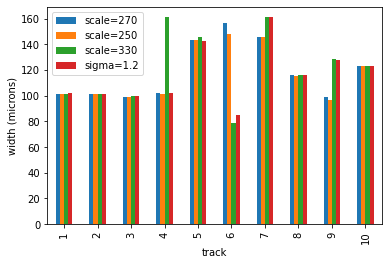

In [21]:
wd=dfm.plot(y=['width (scale=270)','width (scale=250)','width (scale=330)','width (sigma=1.2)'],x='track',xlabel='track',ylabel='width (microns)',kind='bar')
wd.legend(['scale=270','scale=250','scale=330','sigma=1.2'])

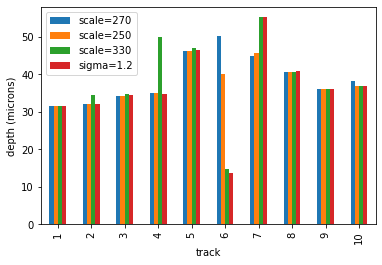

In [22]:
dp=dfm.plot(y=['depth (scale=270)','depth (scale=250)','depth (scale=330)','depth (sigma=1.2)'],x='track',xlabel='track',ylabel='depth (microns)',kind='bar')
dp.legend(['scale=270','scale=250','scale=330','sigma=1.2'])

<AxesSubplot:xlabel='track', ylabel='width (microns)'>

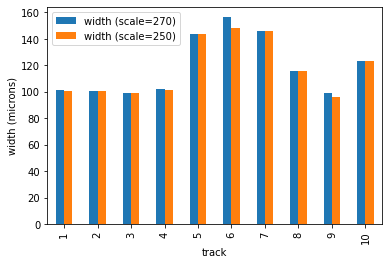

In [23]:
dfm.plot(y=['width (scale=270)','width (scale=250)'],x='track',xlabel='track',ylabel='width (microns)',kind='bar')

<AxesSubplot:xlabel='track', ylabel='length (microns)'>

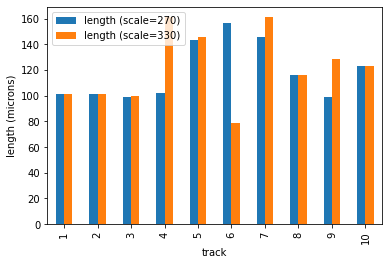

In [51]:
dfm.plot(y=['width (scale=270)','width (scale=330)'],x='track',xlabel='track',ylabel='width (microns)',kind='bar')

<AxesSubplot:xlabel='track', ylabel='width (microns)'>

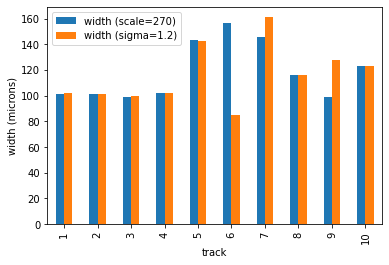

In [24]:
dfm.plot(y=['width (scale=270)','width (sigma=1.2)'],x='track',xlabel='track',ylabel='width (microns)',kind='bar')

#### Notes

In [ ]:
# 270 is the scaling used for all the other notebooks.
# 250 gives a more accurate measurement for track 6, but a less accurate measurement of track 9
# 330 gives a more accurate measurement for track 9, but misses the melt pool on track 4, 6, and 7
# sigma=1.2 gives a more accurate measurement for track 9, but misses the melt pool on track 6 and 7 (1.2 increases the blur
# effect on the image prior to applying the segmentation algorithm)

In [25]:
bboxes=measure1[2]
bboxes2=measure2[2]
bboxes3=measure3[2]
bboxes4=measure4[2]

#### plot_bbox
This method helps show plots from different segmentation parameter sets.

Parameters:
- index - the image to display (use indices in the dataframe at the end of the notebook)
- n - the parameter set to take boxes from: (1) scale=270, (2) scale=250, (3) scale=330, (4) sigma=1.2

Returns:
- melt pool image with box used for measurements showing

In [26]:
def plot_bbox(index,n):
    fig, ax = plt.subplots()
    if n==1:
        minr,minc,maxr,maxc=bboxes[index]
    elif n==2:
        minr,minc,maxr,maxc=bboxes2[index]
    elif n==3:
        minr,minc,maxr,maxc=bboxes3[index]
    else:
        minr,minc,maxr,maxc=bboxes4[index]
    ax.imshow(result[index][900:1800,800:3400])
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
    plt.show()

In [46]:
#showing 270 bad plots: (plot for 9 is similar for scale=250)

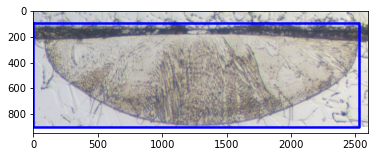

In [27]:
plot_bbox(4,1) #track 6 

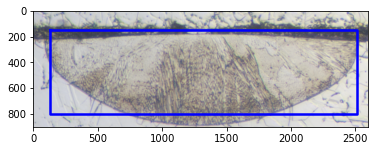

In [28]:
plot_bbox(4,2) #track 6, scale=250

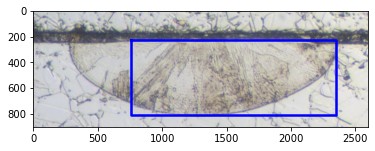

In [29]:
plot_bbox(9,1) #track 9

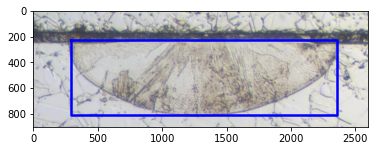

In [30]:
plot_bbox(9,3)

In [31]:
#showing 330 bad plots: (plots 6 and 7 are similar for sigma=1.2)

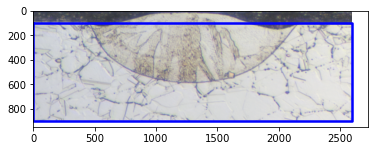

In [32]:
plot_bbox(1,3) #track 4

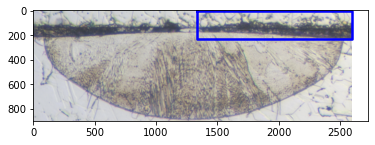

In [33]:
plot_bbox(4,3) #track 6

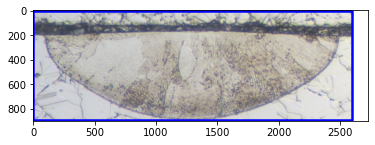

In [34]:
plot_bbox(7,3) #track 7

In [38]:
dfm.sort_index()

,width (scale=270),depth (scale=270),width (scale=250),depth (scale=250),width (scale=330),depth (scale=330),width (sigma=1.2),depth (sigma=1.2),track
0,116.002,40.672,115.568,40.672,116.312,40.548,115.878,40.858,8
1,102.238,35.092,101.184,35.092,161.200,49.786,102.114,34.782,4
2,99.200,34.100,99.200,34.100,99.696,34.782,99.634,34.472,3
3,101.246,31.620,100.874,31.620,101.308,31.496,102.300,31.434,1
4,156.612,50.034,147.994,40.052,78.368,14.632,84.816,13.640,6
5,122.946,38.130,122.946,36.704,123.194,36.766,123.194,36.766,10
6,100.936,31.992,100.936,32.054,101.122,34.410,101.308,31.930,2
7,145.948,44.888,145.948,45.632,161.200,55.180,161.200,55.242,7
8,143.406,46.252,143.406,46.190,145.886,47.058,142.724,46.438,5
9,98.766,36.146,96.410,36.084,128.092,36.084,127.658,36.146,9


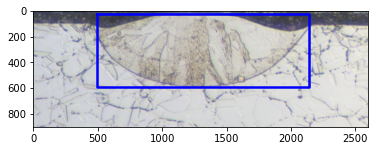

In [35]:
plot_bbox(1,1)